In [1]:
import numpy as np
import pandas as pd

import GPUtil
# #imports from python 3.8
import tensorflow as tf
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score
from sklearn.preprocessing import PowerTransformer, PolynomialFeatures, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

from scipy.stats import skew
from joblib import dump, load


In [2]:
import subprocess

def get_gpu_details():
    try:
        result = subprocess.run(['nvidia-smi'], capture_output=True)
        output = result.stdout.decode('utf-8')
        print(output)
    except FileNotFoundError:
        print("nvidia-smi not found. Please make sure NVIDIA drivers are installed.")

# Call the function to display GPU details
get_gpu_details()

Sat May 11 17:25:44 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.67                 Driver Version: 536.67       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1650      WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   54C    P8               6W /  55W |    332MiB /  4096MiB |      1%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
# pip install torch 

In [3]:
import torch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Device: ",device)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# # export CUDA_VISIBLE_DEVICES=0
# GPUtil.getAvailable()
# use_cuda = torch.cuda.is_available()
# if use_cuda:
#     print('__CUDNN VERSION:', torch.backends.cudnn.version())
#     print('__Number CUDA Devices:', torch.cuda.device_count())
#     print('__CUDA Device Name:',torch.cuda.get_device_name(0))
#     print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)
# else:
#     print("None")


print(tf.config.list_physical_devices('GPU'))

Device:  cpu
Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
import sys
import tensorflow as tf
print("Tensorflow version:", tf.__version__)
print(sys.version)
tf.test.is_gpu_available()

Tensorflow version: 2.10.0
3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [5]:
df = pd.read_csv('./data/data_raw.csv')

## Reuse CNN model in Task 1

In [6]:
# Load model
model = tf.keras.models.load_model('model4.h5')

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
import cv2

def predict_single_image(image_path, model, target_size=(150, 150)):
    # Load and preprocess the image
    img = load_img(image_path, target_size=target_size)  # Load and resize the image
    
    img_array = img_to_array(img)  # Convert the image to a numpy array
    img_array = img_array / 255.0  # Normalize the image array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    
    
    # # Load the model if given as a path
    # if isinstance(model, str):
    #     model = load_model(model)

    # Predict the class
    prediction = model.predict(img_array)
    print(prediction)
    predicted_class = np.argmax(prediction, axis=1)
    print(predicted_class)

    # Optionally, decode the predictions
    # Assuming you have a mapping of class indices to labels
    class_labels = {0: 'beds', 1: 'chairs', 2: 'dressers', 3: 'lamps', 4: 'sofas', 5: 'tables'}
    predicted_label = class_labels[predicted_class[0]]

    # Display the image and the prediction
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_label}")
    plt.axis('off')  # Turn off axis labels
    plt.show()

    return predicted_label


1/1 [==============================] - 4s 4s/step
[[9.8830169e-01 2.7873099e-03 5.1235659e-03 2.1111390e-04 2.5156750e-03
  1.0607308e-03]]
[0]


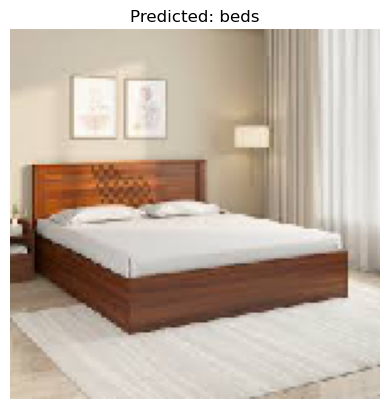

Predicted Label: beds


In [8]:
query_image_path = './query_image/bed_images.jpg'
predicted_label = predict_single_image(query_image_path, model)
print("Predicted Label:", predicted_label)


In [9]:
def match_label_in_path(path):
    # Split the path by '/' and check if predicted_label is in the resulting list
    return predicted_label in path.replace('\\', '/').split('/')

# Apply the function to the 'ImgPath' column and filter the DataFrame
df_matching_labels = df[df['ImgPath'].apply(match_label_in_path)]
df_matching_labels.head()


,ImgPath,Class
0,data/Furniture_Data\beds\Asian\19726asian-dayb...,beds
1,data/Furniture_Data\beds\Asian\20027asian-cano...,beds
2,data/Furniture_Data\beds\Asian\20109asian-pane...,beds
3,data/Furniture_Data\beds\Asian\20508asian-plat...,beds
4,data/Furniture_Data\beds\Asian\20750asian-comf...,beds


In [40]:
import cv2
import numpy as np
import os
import mahotas.features.texture as texture
from tkinter import Tk
from tkinter.filedialog import askopenfilename
# Prompt the user to browse and select the query image
bins = 32
# Tk().withdraw()  # Hide the main window
# query_image_path = askopenfilename( title="Select the input Image")

# Read the query image
query_image = cv2.imread(query_image_path)

# Calculate the color histogram for the query image
query_histogram = cv2.calcHist([query_image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
query_histogram = cv2.normalize(query_histogram, query_histogram).flatten()

# Calculate the texture features for the query image
query_gray_image = cv2.cvtColor(query_image, cv2.COLOR_BGR2GRAY)
query_glcm = texture.haralick(query_gray_image)
query_texture_features = np.mean(query_glcm, axis=0)

# Threshold the query image to obtain a binary image
# _, query_thresholded = cv2.threshold(query_gray_image, 127, 255, cv2.THRESH_BINARY)
_, query_thresholded = cv2.threshold(query_gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Find contours in the binary image
query_contours, _ = cv2.findContours(query_thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
if query_contours:
    query_contour = max(query_contours, key=cv2.contourArea)
    query_area = cv2.contourArea(query_contour)
    query_perimeter = cv2.arcLength(query_contour, True)
    query_compactness = query_perimeter / np.sqrt(query_area) if query_area > 0 else 0
else:
    query_compactness = 0  # Handle no contours found

# # Calculate the contour area and perimeter for the query image
# query_contour = query_contours[0]
# query_area = cv2.contourArea(query_contour)
# query_perimeter = cv2.arcLength(query_contour, True)

# Calculate the compactness as the ratio of perimeter to the square root of area for the query image
# query_compactness = query_perimeter / np.sqrt(query_area)

In [41]:
df_matching_labels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6578 entries, 0 to 6577
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ImgPath  6578 non-null   object
 1   Class    6578 non-null   object
dtypes: object(2)
memory usage: 154.2+ KB


In [42]:
import cv2
import numpy as np
import mahotas.features.texture as texture

bins = 32
features_dict = {}
with tf.device('GPU:0'):
    for index, row in df_matching_labels.iterrows():
        image_path = row['ImgPath']
        image = cv2.imread(image_path)
    
        if image is None:
            print(f"Failed to load image at {image_path}")
            continue
    
        # Calculate the color histogram for the image
        histogram = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
        histogram = cv2.normalize(histogram, histogram).flatten()
    
        # Calculate the texture features for the image
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        glcm = texture.haralick(gray_image)
        texture_features = np.mean(glcm, axis=0)
    
        # Adaptive thresholding
        thresh_value, thresholded = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
        # Find contours in the binary image
        contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if contours:
            # Use the largest contour if multiple are found
            contour = max(contours, key=cv2.contourArea)
            area = cv2.contourArea(contour)
            perimeter = cv2.arcLength(contour, True)
            compactness = perimeter / np.sqrt(area) if area != 0 else 0
        else:
            area = 0
            perimeter = 0
            compactness = 0
    
        # Store the features in the dictionary with the image filename as the key
        features_dict[image_path] = (histogram, texture_features, compactness)


In [97]:
import numpy as np

def calculate_weighted_distance(color_distance, texture_distance, shape_distance):
    # Constants to control the emphasis of each feature
    alpha = 5    # Weight for color distance
    beta = 100    # Weight for texture distance
    gamma = 40   # Weight for shape distance

    # Applying logarithmic scaling to distances
    # Adding 1 inside the log function to avoid log(0) which is undefined
    log_color_distance = np.log1p(color_distance)
    log_texture_distance = np.log1p(texture_distance)
    log_shape_distance = np.log1p(shape_distance)

    # Calculate weighted sum of logarithmic distances
    weighted_distance = alpha * log_color_distance + beta * log_texture_distance + gamma * log_shape_distance
    return weighted_distance

Similar images:
Image: data/Furniture_Data\beds\Transitional\8050transitional-panel-beds.jpg
Image: data/Furniture_Data\beds\Farmhouse\7596farmhouse-sleigh-beds.jpg
Image: data/Furniture_Data\beds\Contemporary\1329contemporary-platform-beds.jpg
Image: data/Furniture_Data\beds\Southwestern\9091southwestern-platform-beds.jpg
Image: data/Furniture_Data\beds\Contemporary\1964contemporary-panel-beds.jpg
Image: data/Furniture_Data\beds\Traditional\7435traditional-kids-beds.jpg
Image: data/Furniture_Data\beds\Transitional\9453transitional-panel-beds.jpg
Image: data/Furniture_Data\beds\Transitional\2526transitional-platform-beds.jpg
Image: data/Furniture_Data\beds\Contemporary\1433contemporary-panel-beds.jpg
Image: data/Furniture_Data\beds\Contemporary\2461contemporary-panel-beds.jpg


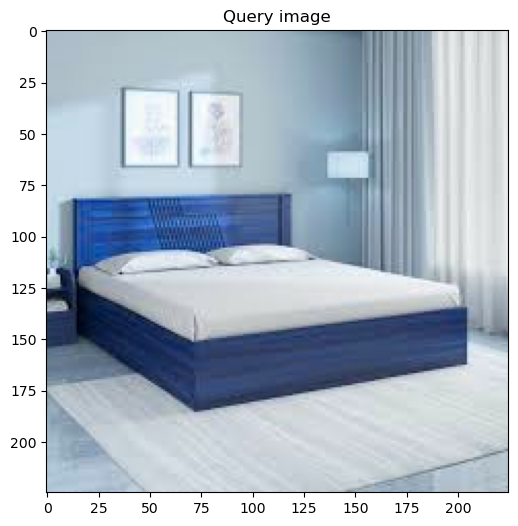

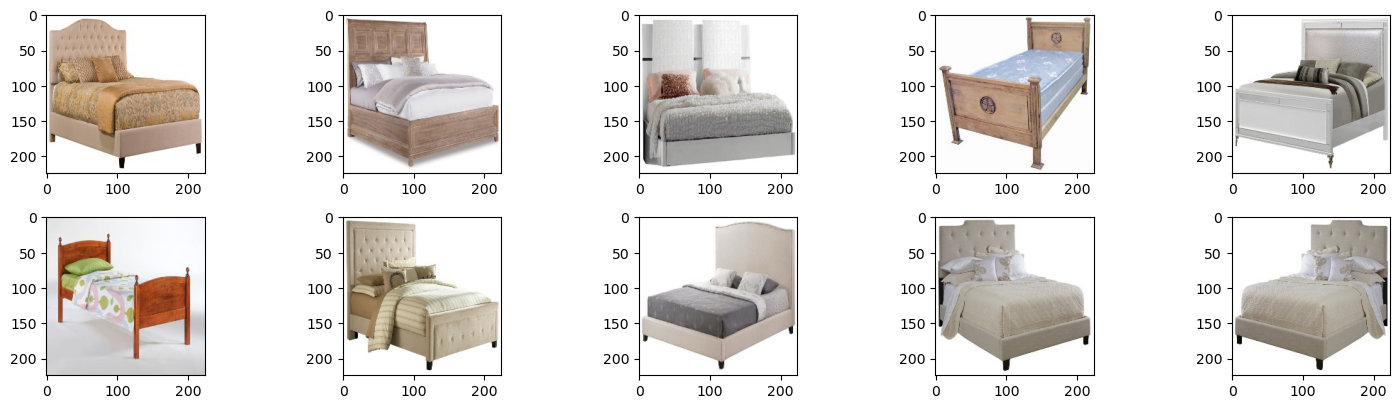

In [98]:
import matplotlib.pyplot as plt
# Define the number of similar images to retrieve
k = 10

# Perform nearest neighbor search based on feature vectors
similar_images = []
for image_file, (histogram, texture_features, compactness) in features_dict.items():
    # Calculate the distance between the query image features and the current image features
    color_distance = cv2.compareHist(query_histogram, histogram, cv2.HISTCMP_CHISQR)
    texture_distance = np.linalg.norm(query_texture_features - texture_features)
    shape_distance = np.abs(query_compactness - compactness)
    # distance = 2 * color_distance + 10 * texture_distance + 50 * shape_distance
    distance = calculate_weighted_distance(color_distance, texture_distance, shape_distance)
#     distance =  texture_distance + shape_distance
    similar_images.append((image_file, distance))

# Sort the similar images based on distance
similar_images.sort(key=lambda x: x[1])
# similar_images.sort()
# print(similar_images[0][1], similar_images[1][1])


plt.figure(figsize=(8, 6))
plt.imshow(query_image)
plt.title("Query image")


# Display the top k similar images
print(f"Similar images:")

plt.figure(figsize=(15, 8))
plt.rc('axes', labelsize=15)  
for i in range(k):
    image_file, distance = similar_images[i]
    print(f"Image: {image_file}")
    plt.subplot(4, 5, i + 1)
    similar_image = cv2.imread(image_file)
    # Convert the BGR image to RGB for Matplotlib
    similar_image_rgb = cv2.cvtColor(similar_image, cv2.COLOR_BGR2RGB)
    plt.imshow(similar_image_rgb)
    # plt.xlabel(f"Image: {image_file}")

plt.tight_layout()
plt.show()

# for i in range(k):
#     image_file, distance = similar_images[i]
#     print(f"Image: {image_file}")
    
#     # # Load and display the similar image using Matplotlib
#     # similar_image_path = os.path.join(folder_path, image_file)
#     similar_image = cv2.imread(image_file)
    
#     # Convert the BGR image to RGB for Matplotlib
#     similar_image_rgb = cv2.cvtColor(similar_image, cv2.COLOR_BGR2RGB)
    
#     # Display the image using Matplotlib
#     plt.imshow(similar_image_rgb)
#     plt.axis('off')  # Turn off axis labels
#     plt.show()

In [9]:
def preprocess(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Define an initial mask
    mask = np.zeros(image.shape[:2], np.uint8)
    
    # Define background and foreground models (used by the grabcut algorithm)
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)
    
    # Define a rectangle around the foreground are
    rect = (50, 30, 500, 500)  # Adjust these values for your specific image
    
    # Apply GrabCut
    cv2.grabCut(image, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)
    
    # Modify the mask
    mask2 = np.where((mask==2)|(mask==0), 0, 1).astype('uint8')
    
    # Apply mask to the image
    image = image * mask2[:, :, np.newaxis]
    
    # Replace background with white color
    image[mask2 == 0] = [255, 255, 255]
    return image

In [109]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
import cv2

def predict_single_image(image_path, model, target_size=(150, 150)):
    # Load and preprocess the image
    original_img = load_img(image_path)  # Load and resize the image
    image = preprocess(image_path)
    # print(image.dtype)
    img = cv2.resize(image, (150,150))
    # print(img.shape)
    
    img_array = img_to_array(img)  # Convert the image to a numpy array
    img_array = img_array / 255.0  # Normalize the image array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    
    
    # # Load the model if given as a path
    # if isinstance(model, str):
    #     model = load_model(model)

    # Predict the class
    prediction = model.predict(img_array)
    print(prediction)
    predicted_class = np.argmax(prediction, axis=1)
    print(predicted_class)

    # Optionally, decode the predictions
    # Assuming you have a mapping of class indices to labels
    class_labels = {0: 'beds', 1: 'chairs', 2: 'dressers', 3: 'lamps', 4: 'sofas', 5: 'tables'}
    predicted_label = class_labels[predicted_class[0]]

    # Display the image and the prediction
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_label}")
    plt.axis('off')  # Turn off axis labels
    plt.show()

    return predicted_label


1/1 [==============================] - 0s 26ms/step
[[0.01583571 0.685705   0.00261594 0.01999603 0.00302915 0.27281815]]
[1]


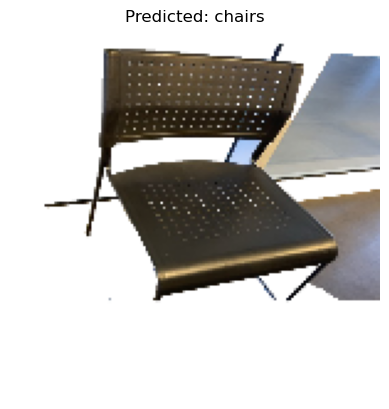

Predicted Label: chairs


In [110]:
image_path = './query_image/download (1).jpg'
# model = tf.keras.models.load_model('model1.h5')
# Call the function
predicted_label = predict_single_image(image_path, model)
print("Predicted Label:", predicted_label)


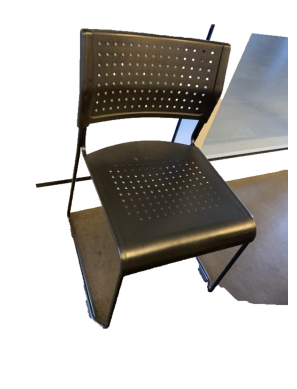

In [88]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image
image = cv2.imread('./query_image/download (1).jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Define an initial mask
mask = np.zeros(image.shape[:2], np.uint8)

# Define background and foreground models (used by the grabcut algorithm)
bgdModel = np.zeros((1, 65), np.float64)
fgdModel = np.zeros((1, 65), np.float64)

# Define a rectangle around the foreground are
rect = (50, 30, 500, 600)  # Adjust these values for your specific image

# Apply GrabCut
cv2.grabCut(image, mask, rect, bgdModel, fgdModel,5, cv2.GC_INIT_WITH_RECT)

# Modify the mask
mask2 = np.where((mask==2)|(mask==0), 0, 1).astype('uint8')

# Apply mask to the image
image = image * mask2[:, :, np.newaxis]

# Replace background with white color
image[mask2 == 0] = [255, 255, 255]

# Display the result
plt.imshow(image)
plt.axis('off')
plt.show()
